# Published single-cell transcriptomics data & tools

Query date: 2024/07/03

For more information and use orginal code please see https://www.kallistobus.tools/tutorials/scrna-seq_intro/python/scrna-seq_intro/

Raw data available at https://docs.google.com/spreadsheets/d/1En7-UV0k0laDiIfjFkdn7dggyR7jIk3WH8QgXaMOZF0/edit#gid=0

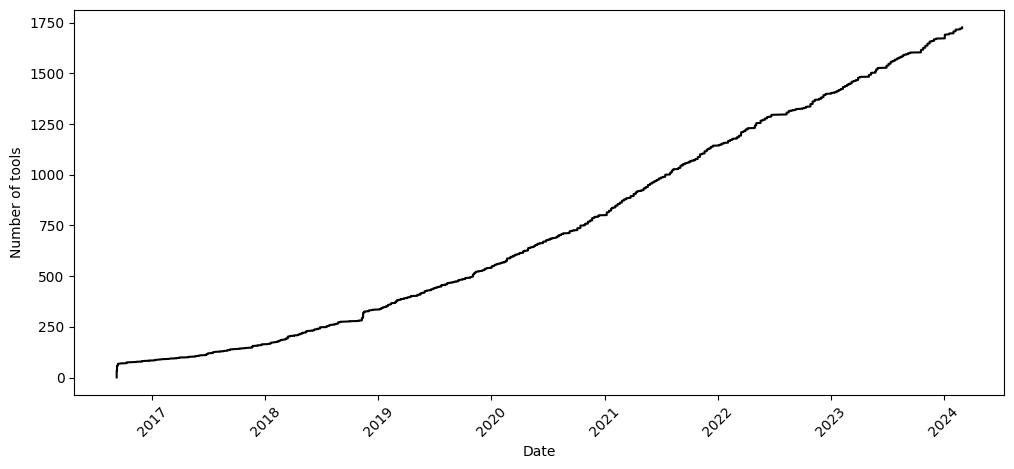

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Growth of single-cell tools
tools = pd.read_csv('https://raw.githubusercontent.com/Oshlack/scRNA-tools/master/database/tools.tsv', sep='\t')
tools["Datetime"] = pd.to_datetime(tools["Added"])
tools = tools.sort_values("Added")
tools["count"] = 1

fig, ax = plt.subplots(figsize=(12, 5))

x = tools.Datetime
y = tools["count"].groupby(tools.Datetime.dt.time).cumsum()

ax.plot(x, y, color="k")
ax.set_xlabel("Date")
ax.set_ylabel("Number of tools")
ax.tick_params(axis='x', rotation=45)

plt.show()

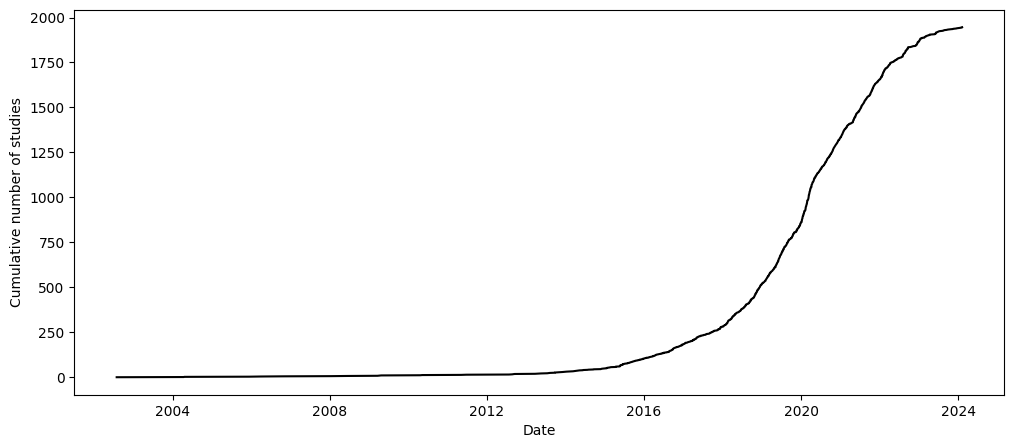

In [2]:
#title Growth of single-cell RNA-seq
df = pd.read_csv('http://nxn.se/single-cell-studies/data.tsv', sep='\t')
# converts string to date format, can only be run once!
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# converts string of reported cells total to float, can only be run once!
df['Reported cells total'] = df['Reported cells total'].str.replace(',', '').map(float)

# plot number of studies over time
fig, ax = plt.subplots(figsize=(12, 5))

papers = pd.read_csv('http://nxn.se/single-cell-studies/data.tsv', sep='\t')
papers['Datetime'] = pd.to_datetime(papers['Date'], format='%Y%m%d')
papers = papers.sort_values("Date")
papers["count"] = 1

x = papers.Datetime
y = papers["count"].groupby(papers.Datetime.dt.time).cumsum()

ax.plot(x, y, color="k")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative number of studies")

plt.show()

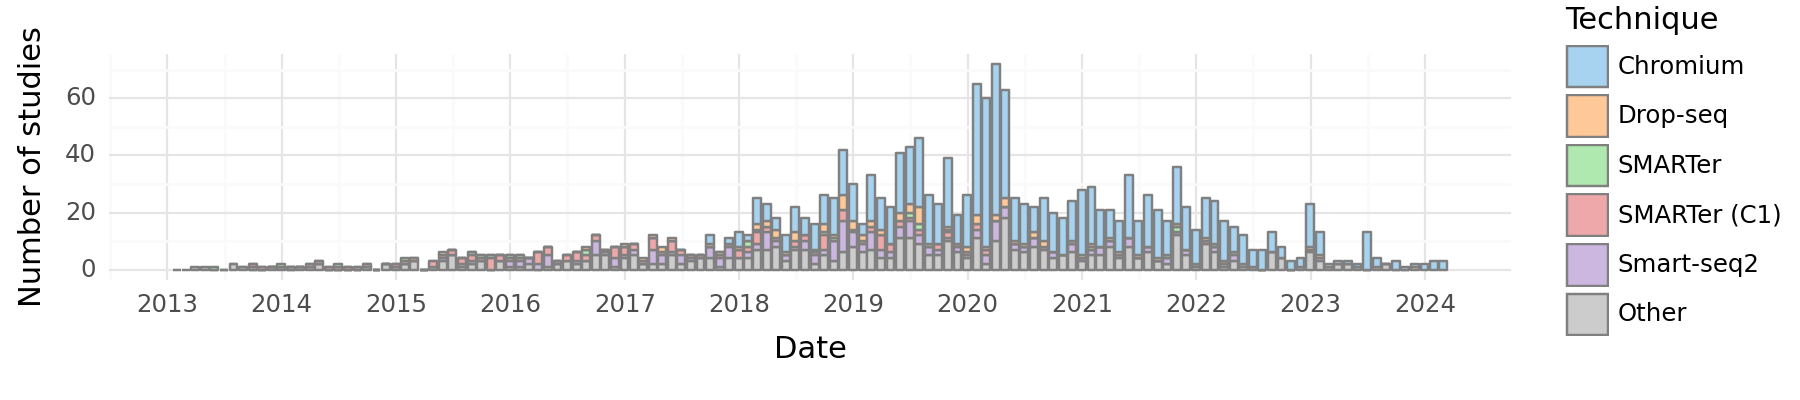

In [3]:
import colorsys
import matplotlib.colors as mplcol
import plotnine as p
from mizani.breaks import date_breaks
from mizani.formatters import date_format

# Technologies used
def tidy_split(df, column, sep='|', keep=False):

    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values

    return new_df

ts = pd.Timestamp

tdf = tidy_split(df, 'Technique', ' & ')
t_dict = {k: k for k in tdf['Technique'].value_counts().head(5).index}
tdf['Technique'] = tdf['Technique'].map(lambda s: t_dict.get(s, 'Other'))
techs = list(
    tdf['Technique']
    .value_counts()
    .sort_index()
    .index
    .difference(['Other'])
)
techs.append('Other')
tdf['Technique'] = (
    pd.Categorical(
       tdf['Technique'],
        categories=techs,
        ordered=True
    )
)

def desaturate(color, prop):

    # Check inputs
#     if not 0 <= prop <= 1:
#         raise ValueError("prop must be between 0 and 1")

    # Get rgb tuple rep
    rgb = mplcol.colorConverter.to_rgb(color)

    # Convert to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)

    # Desaturate the saturation channel
#     l *= prop
    l = 0.8

    # Convert back to rgb
    new_color = colorsys.hls_to_rgb(h, l, s)

    hex_color = '#{:02x}{:02x}{:02x}'.format(*map(lambda c: int(c * 255), new_color))

    return hex_color

    # lighten matplotlib default colors
clrs = list(map(lambda c: desaturate(c, 1.2), ['C0', 'C1', 'C2', 'C3', 'C4', 'black']))

#### Plot number of studies per month by technique

per_month = (
    tdf
    .groupby('Technique')
    .resample('1M', on='Date')
    .count()['DOI']
    .reset_index()
)
date_filter = pd.to_datetime('2013-01-01T01:01:01')
filtered_data = per_month.query('Date > @date_filter')
p.options.figure_size = (9, 2)
fig = (
    p.ggplot(data=filtered_data,
             mapping=p.aes(x='Date', y='DOI', fill='Technique'))
    + p.geom_bar(stat='identity', color='grey')
    + p.theme_minimal(base_family='DejaVu Sans')
    + p.scale_x_datetime(breaks=date_breaks('1 years'), labels=date_format('%Y'))
    + p.labs(y='Number of studies')
    + p.scale_fill_manual(values=clrs)
)

print(fig)